In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Model Assumptions and Explaination

1. Sex determination for larval happens at metamorphism, since research cannot distinguish sex reversal and labile sex determination.
2. Growth rate is the same for all larval ages.
3. The ecosystem only involves larval, male and female juvenile, fish, and parasite.
4. Larval is filter feeder and their food source depends on E, the environment variable between 0 and 1, the reproducibility of the environment, such as algae availability.
5. E is the reproducibility of the environment, such as algae availability. E is between 0 and 1. 0 for lentic environment with the lowest food availability. 1 for stream environment with highest availability.
6. E is not affected by anything in the ecosystem, and is picked by hand.
7. All species have a capacity picked by hand. Such as L_max for larval, P_max for parasites. Saturation approaches 1 as population approaches capacity, 0 as population approaches 0.
6. Larval death rate increases as larval saturation increase and E decreases.
7. Male and Female death rate increases as saturation increases and as fish saturation decreases.
8. Ratio for larval to be come male is 0.78 when E is 0, 0.56 when E is 1, during metamorphism.
9. Male and Female both die shortly after reproduction. Male also dies because they also travel upstream to make nest.
10. The birth rate for larval is also limited by larval saturation. Meaning less eggs hatch when larval approaches max capacity.
11. Fish growth slows as fish saturates. Fish die more as parasites saturates.
12. Parasites growth increases as fish saturates and as larval saturates (assuming juvenile indirectly saturates due to this. No saturation is measured for juvenile to reduce complexity). Death for parasite is vice versa.


In [22]:
class Model:
    def __init__(
            self,
            seed=42,
            num_years=100,
            Larva_init=5000,
            Female_init=1000,
            Male_init=1000,
            Fish_init=30000,
            # environment
            E='const',
            noise_E=0.001,
            # sex ratio change
            constant_male_ratio=None, # None or number between 0.56 and 0.78
            # metamorphism rate
            constant_metamorphism_rate=None # None or number between 1/3 and 1/10
            ):
        np.random.seed(seed)

        ######### Coefficients
        # larva
        self._L_max = 60000 # capacity for larva, we can tune all the max
        self._death_rate_L = 0.6 # death rate of larva

        # juvenile (M and F)
        self._death_rate_J = 0.3 # natural death rate for juvenile
        self._reproduce_rate = 0.5 # when they reproduce they also die shortly after
        self._birth_rate = 60000 * 0.0005 * self._reproduce_rate # birth rate by adult female 30000 eggs per birth, 10% survive, 0.8 birth per year then die
        self._J_max = 10000

        # fish
        self._growth_rate_H = 0.3 # natural growth rate for fish
        self._death_rate_H = 0.2 # natural death rate of fish
        self._H_max = 60000 # capacity for fish

        # parasite
        self._kill_rate = 0.1 # kill rate for fish by a unit of parasite
        self._P_max = 1000 # capacity for parasite
        self._growth_rate_P = 1 # parasite growth rate
        self._death_rate_P = 1 # natural death rate for parasite

        # param
        self.constant_male_ratio = constant_male_ratio
        if self.constant_male_ratio is not None:
            self.constant_male_ratio = max(min(self.constant_male_ratio, 0.78), 0.56) # between 0.56 and 0.78

        self.constant_metamorphism_rate = constant_metamorphism_rate
        if self.constant_metamorphism_rate is not None:
            self.constant_metamorphism_rate = max(min(self.constant_metamorphism_rate, 1/3), 1/10) # between 1/10 and 1/3

        ######### Variables
        self.num_years = num_years
        self.years = np.arange(num_years, step=1)

        # larva
        self.L = np.zeros(num_years)
        self.L[0] = Larva_init

        # juvenile female
        self.F = np.zeros(num_years)
        self.F[0] = Female_init

        # juvenile male
        self.M = np.zeros(num_years)
        self.M[0] = Male_init

        # environment
        # TODO: use different environment functions such as random ones
        if E == 'const':
            self.E = 0.5 * np.ones(num_years) # constant at 0.5
        elif E == 'linear':
            self.E = np.linspace(0, 1, num_years)
        else:
            period = 50 # years
            self.E = 0.5 + 0.5 * np.sin(2 * np.pi / period * self.years) # sine
        # apply noise
        noise_E = min(0.5, noise_E)
        self.E = np.clip(self.E + np.random.normal(0, noise_E, size=num_years), 0, 1)

        # fish
        self.H = np.zeros(num_years)
        self.H[0] = Fish_init

        # parasite = female + male
        self.P = np.zeros(num_years)
        self.P[0] = Female_init + Male_init

        self.populate_model()

        print("modeling done")

    def populate_model(self):
        self.df = pd.DataFrame()

        for n in range(1, len(self.years)):
            self.L[n], self.M[n], self.F[n], self.H[n], self.P[n], _ = self.update(n, self.L[n-1], self.M[n-1], self.F[n-1], self.H[n-1], self.P[n-1], self.E[n-1])

    def update(self, year, L_old, M_old, F_old, H_old, P_old, E_old):
        metamorphism_rate = 1/3 - 7/30 * (1 - E_old) if self.constant_metamorphism_rate is None else self.constant_metamorphism_rate
        male_rate = 0.78 - 0.22 * E_old if self.constant_male_ratio is None else self.constant_male_ratio
        female_rate = 1 - male_rate

        # saturation
        fish_saturation = self.saturation(H_old, self._H_max) # between 0 and 1, measures how saturated fish is
        larval_saturation = self.saturation(L_old, self._L_max)
        juvenile_saturation = self.saturation(M_old + F_old, self._J_max)

        # L_new
        # death rate increases as saturation increase and E decreases
        larval_death_rate = 0.5 * self._death_rate_L * larval_saturation + 0.5 * self._death_rate_L * (1 - E_old)
        L_survived_from_last_census = L_old * (1 - metamorphism_rate) * (1 - larval_death_rate) # did not age up and survived
        L_born = F_old * self._birth_rate * (1 - larval_saturation) # new born, assume also hatching limited by saturation (somehow related to environment)
        L_new = L_survived_from_last_census + L_born

        # F_new
        # death rate related to saturation of fish
        # survived and did not reproduce (female die shortly after reproduction, male also travels upstream and die)
        juvenile_death_rate = (1 - self._death_rate_J * (1 - fish_saturation)) * (1 - self._reproduce_rate)
        F_survived_from_last_census = F_old * juvenile_death_rate
        F_metamorphed = L_survived_from_last_census * metamorphism_rate * female_rate
        F_new = F_survived_from_last_census + F_metamorphed

        # M_new
        M_survived_from_last_census = M_old * juvenile_death_rate
        M_metamorphed = L_survived_from_last_census * metamorphism_rate * male_rate
        M_new = M_survived_from_last_census + M_metamorphed

        # H_new
        H_born = H_old * self._growth_rate_H * (1 - fish_saturation)
        # survived both natural death and parasite
        fish_death_rate = self._death_rate_H * larval_saturation
        # H_survived_from_last_census = H_old * (1 - self._death_rate_H) * (1 - self._kill_rate * larval_saturation)
        H_survived_from_last_census = H_old * (1 - fish_death_rate)
        H_new = H_survived_from_last_census + H_born

        # P_new
        # death rate increases as parasite saturation increases, as fish saturation decreases, and as lamprey saturation decreases
        P_new = F_new + M_new

        # E_new
        E_new = E_old * (1 + 0.1 * (0.5 - larval_saturation)) # grow when saturation(larval) < 0.5, decay when saturation(larval) > 0.5
        E_new = min(max(E_new, 0), 1)

        # TODO: calculate anything else useful
        juvenile_natural_deaths = P_old * juvenile_death_rate
        larval_natural_deaths = L_old * larval_death_rate

        new_row = pd.DataFrame([{
            'year': year,
            'E': E_new,
            'L': L_new,
            'F': F_new,
            'M': M_new,
            'H': H_new,
            'P': P_new,
            'metamorphism_rate': metamorphism_rate,
            'male_rate': male_rate,
            'female_rate': female_rate,
            'fish_saturation': fish_saturation,
            'larval_saturation': larval_saturation,
            'juvenile_saturation': juvenile_saturation,
            'larval_deaths': larval_natural_deaths,
            'larval_death_rate': larval_death_rate,
            'larval_survival_rate': 1 - larval_death_rate,
            'juvenile_natural_deaths': juvenile_natural_deaths,
            'juvenile_death_rate': juvenile_death_rate
        }])

        self.df = pd.concat([self.df, new_row], ignore_index=True)

        return (L_new, M_new, F_new, H_new, P_new, E_new)

    def saturation(self, value, maximum):
        # logistic function that return a rate between 0 to 1
        # 0 means not saturated and 1 means saturated
        # closely resembles (value over maximum) but stays between 0 and 1
        # used this because a linear growth rate was causing problem when exceeding 1, and 1 minus that value becomes negative
        # so used logistic here
        mean = maximum / 2
        return 1 / (1 + np.exp(-5 * (value - mean) / maximum))

    def graph_model(self, title="Lamprey Ecosystem Model", Y_lim=None, E_lim=None):
        plt.rcParams.update({
            "font.size": 25,
            "axes.titlesize": 25,
            "axes.labelsize": 25,
            "xtick.labelsize": 25,
            "ytick.labelsize": 25,
            "legend.fontsize": 25,
            "lines.linewidth": 2.5
        })
        
        end = self.num_years

        fig, ax1 = plt.subplots(figsize=(15,15))
        ax2 = ax1.twinx()  # Create a second x-axis sharing the same y-axis
        
        ax1.plot(self.years[:end], self.L[:end], label="Larvae")
        ax1.plot(self.years[:end], self.M[:end], label="Male")
        ax1.plot(self.years[:end], self.F[:end], label="Female")
        ax1.plot(self.years[:end], self.P[:end], label="Parasites (Male+Female)")
        ax1.plot(self.years[:end], self.H[:end], label="Fish")
        ax1.set_ylabel("Population")
        if Y_lim is not None:
            ax1.set_ylim(Y_lim)

        ax2.fill_between(self.years[:end], self.E[:end], color="skyblue", alpha=0.2, label="Environment")
        ax2.set_ylabel("Environment")
        if E_lim is not None:
            ax2.set_ylim(E_lim)

        fig.legend()
        plt.title(title, loc="left")
        plt.show()

        plt.rcParams.update(plt.rcParamsDefault)

modeling done


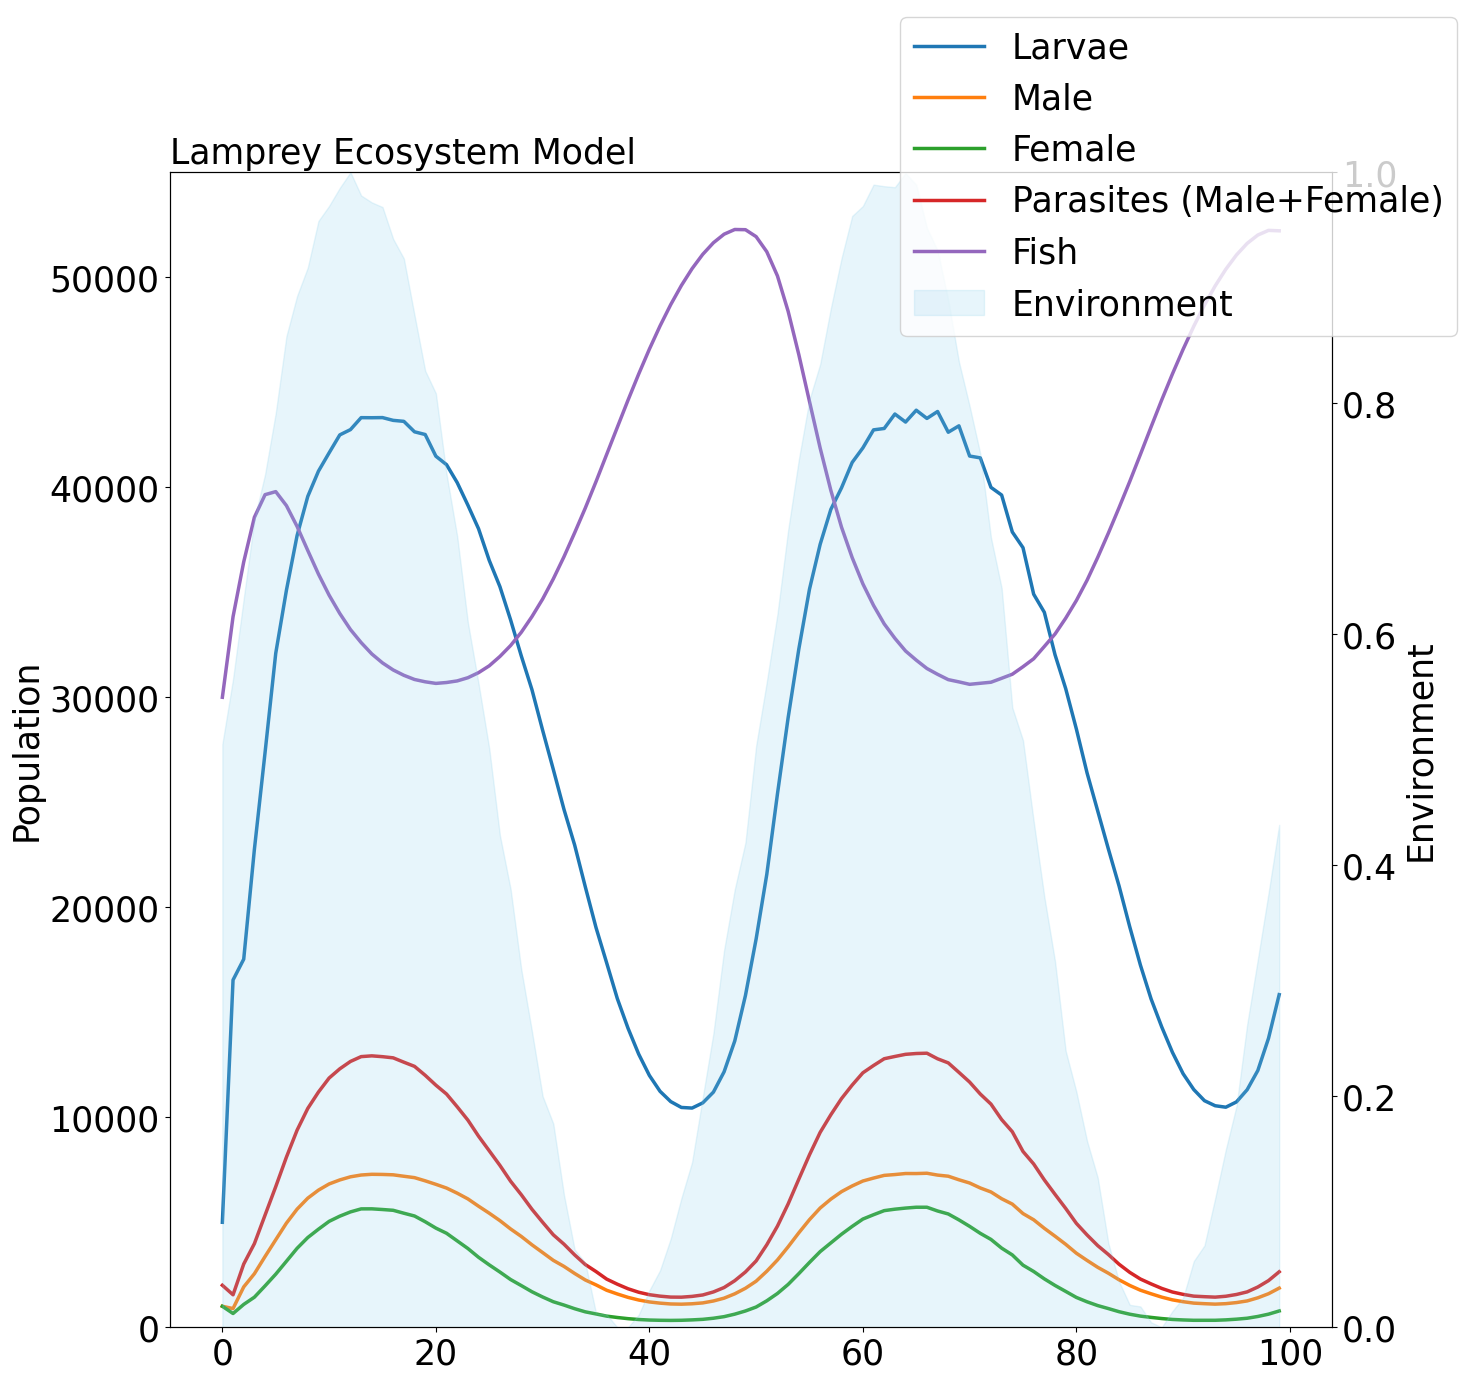

modeling done


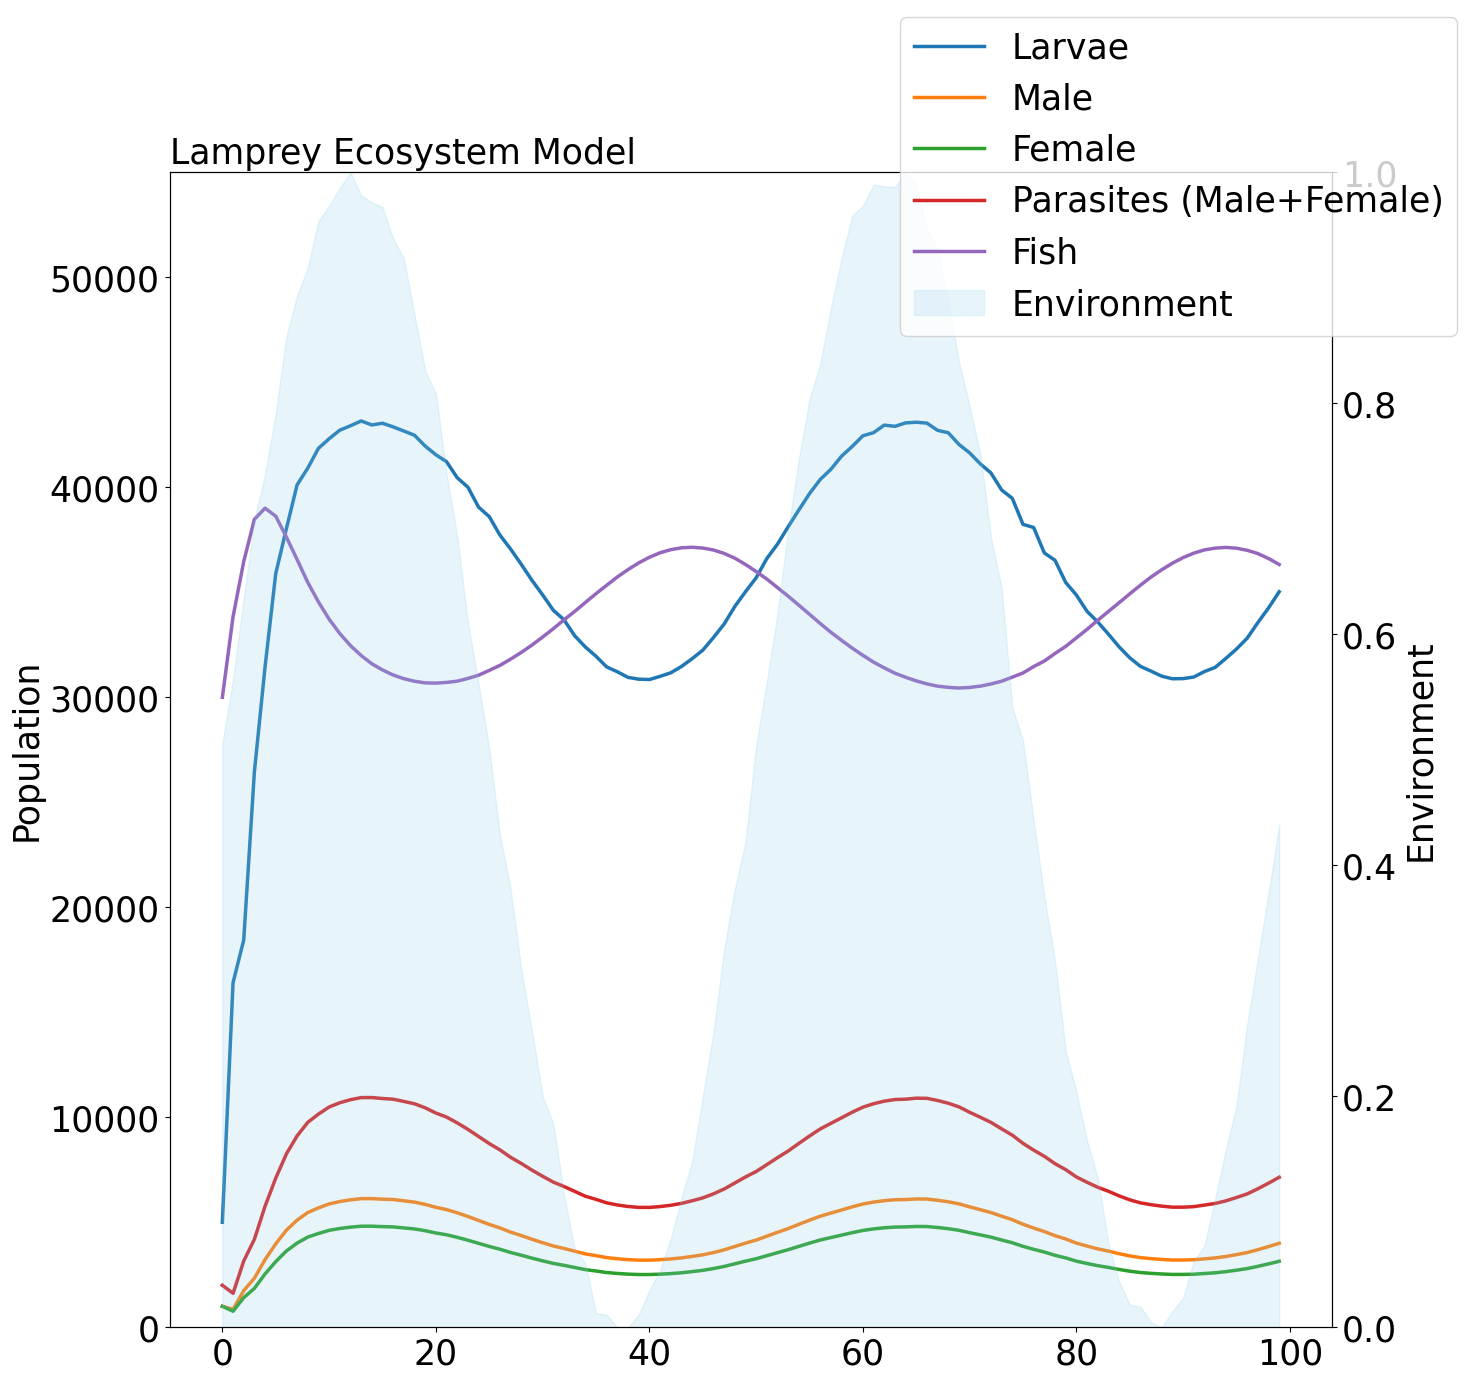

Natural larval deaths with sex ratio change: 8090.543455350482
Natural larval deaths without change: 11950.699587278157
Natural juvenile deaths with sex ratio change: 2917.198452134492
Natural juvenile deaths without change: 3457.4072835542406


In [23]:
model_sex_change = Model(
    noise_E=0.01, # change the noise level for E
    E='sin',
    num_years=100
)
model_sex_change.graph_model(Y_lim=(0, 55000), E_lim=(0, 1))

model_no_change = Model(
    noise_E=0.01, # change the noise level for E
    E='sin',
    num_years=100,
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model(Y_lim=(0, 55000), E_lim=(0, 1))

avg_larval_death_change = np.mean(model_sex_change.df['larval_deaths'])
avg_larval_death_no_change = np.mean(model_no_change.df['larval_deaths'])
print(f'Natural larval deaths with sex ratio change: {avg_larval_death_change}')
print(f'Natural larval deaths without change: {avg_larval_death_no_change}')

avg_juv_death_change = np.mean(model_sex_change.df['juvenile_natural_deaths'])
avg_juv_death_no_change = np.mean(model_no_change.df['juvenile_natural_deaths'])
print(f'Natural juvenile deaths with sex ratio change: {avg_juv_death_change}')
print(f'Natural juvenile deaths without change: {avg_juv_death_no_change}')

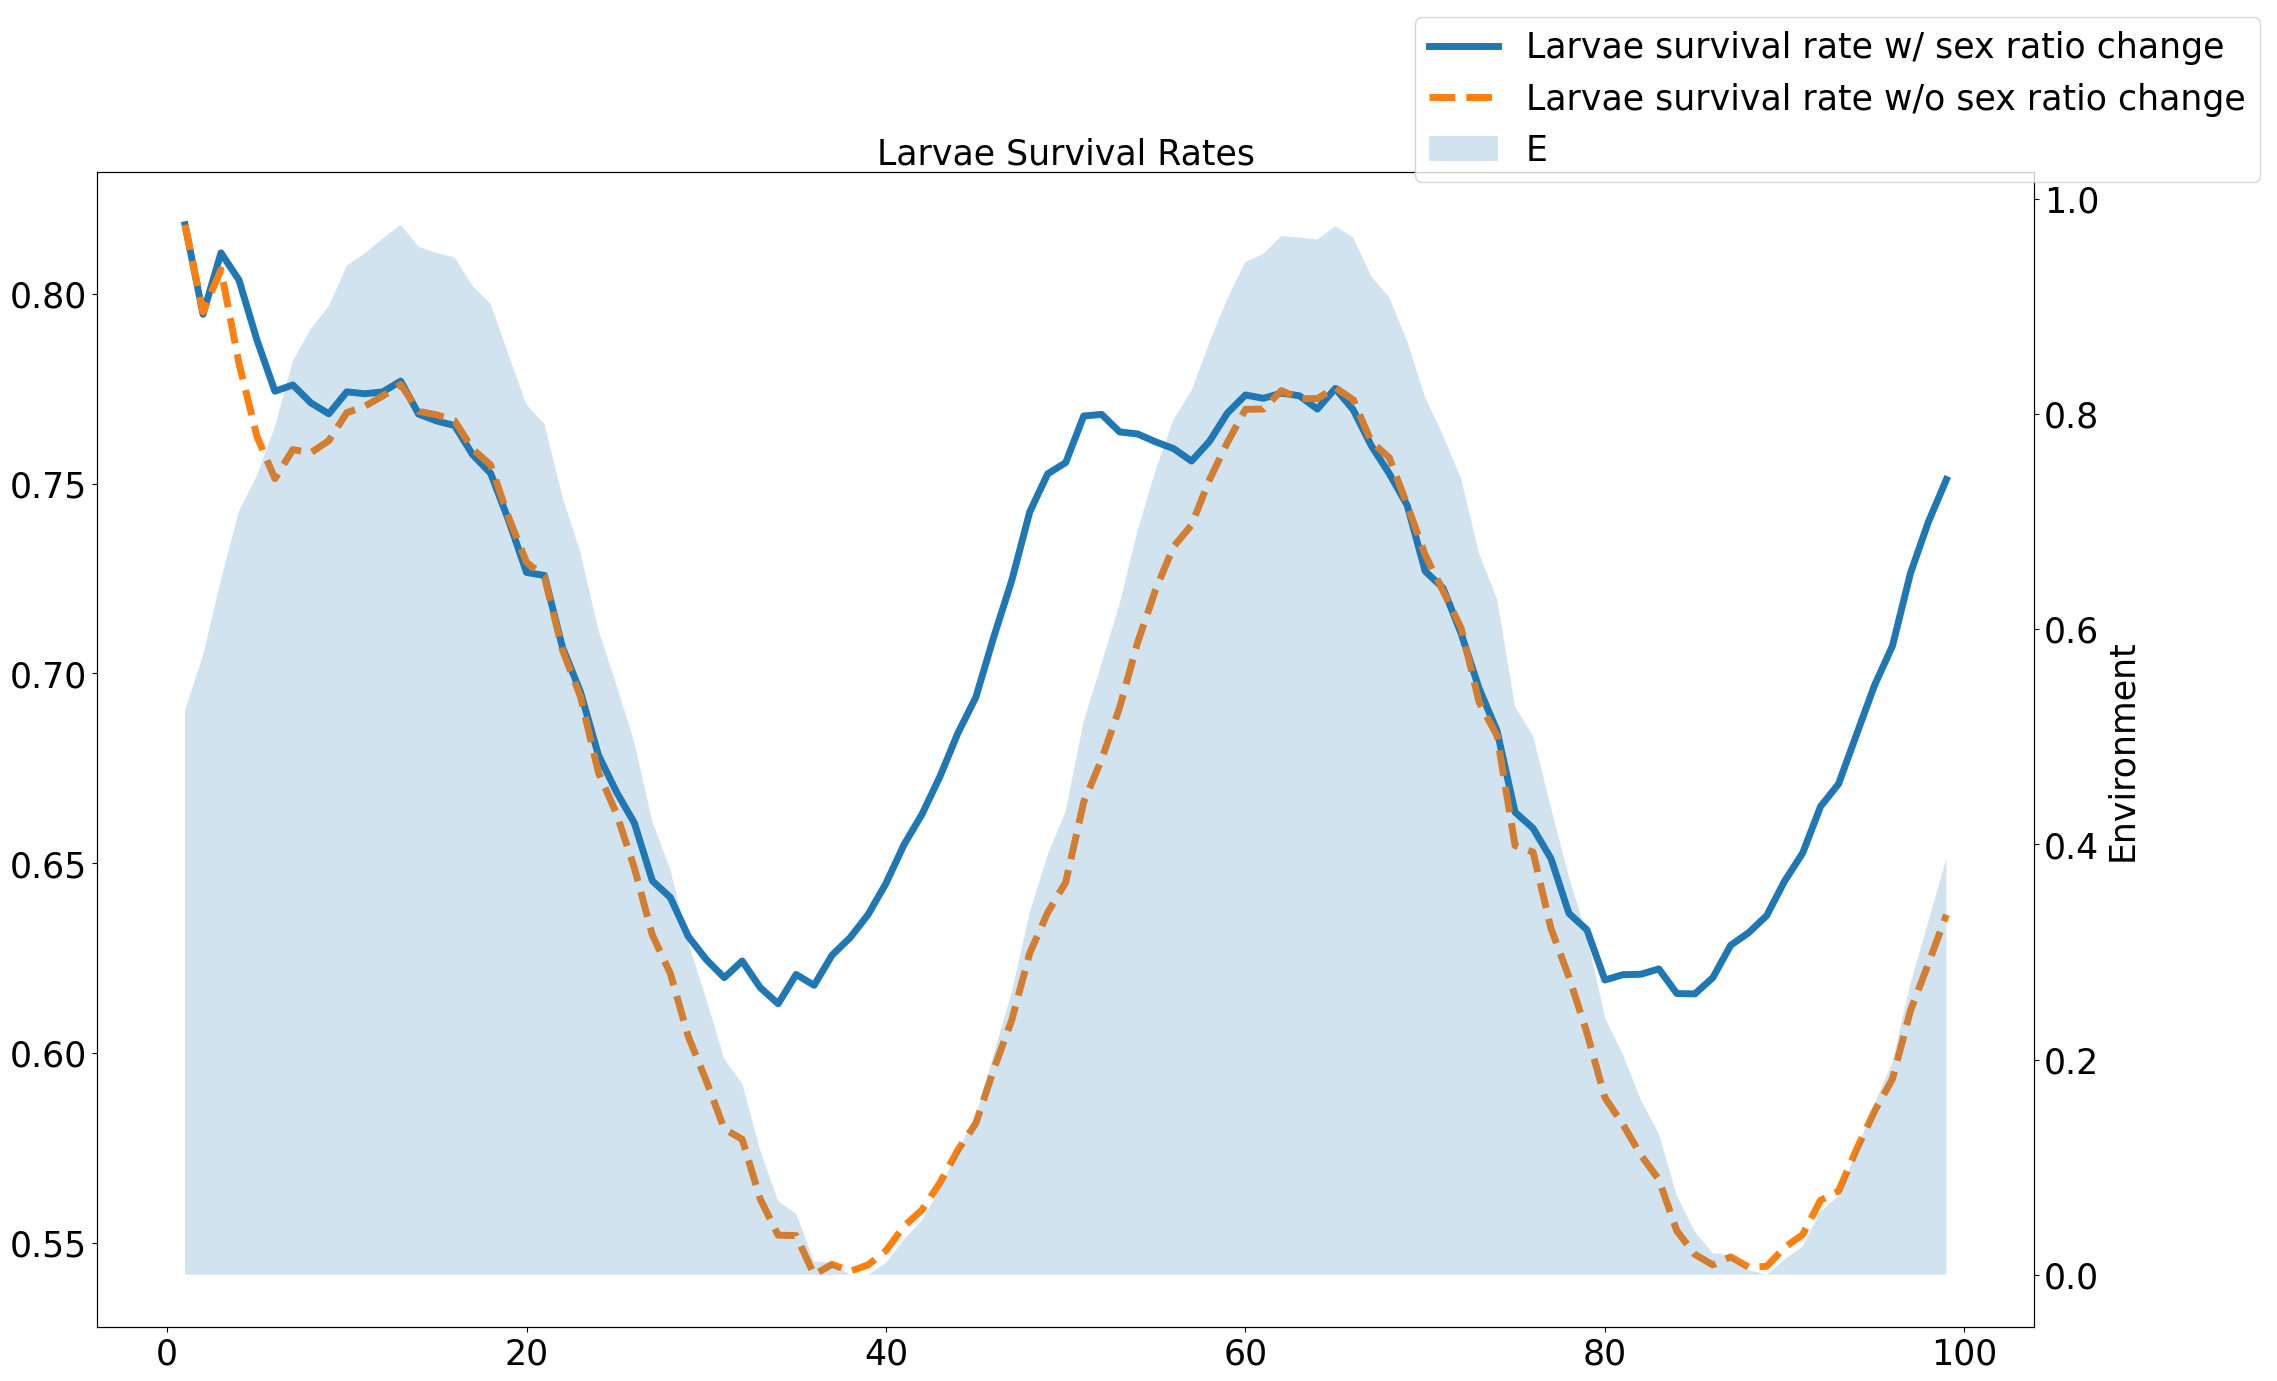

In [18]:
plt.rcParams.update({
            "font.size": 25,
            "axes.titlesize": 25,
            "axes.labelsize": 25,
            "xtick.labelsize": 25,
            "ytick.labelsize": 25,
            "legend.fontsize": 25,
            "lines.linewidth": 5
})

fig, ax1 = plt.subplots(figsize=(25,15))
ax2 = ax1.twinx()  # Create a second x-axis sharing the same y-axis

# ax1.plot(model_sex_change.df["year"], model_sex_change.df["juvenile_death_rate"], label="Juvenile death rate w/ sex ratio change")
# ax1.plot(model_no_change.df["year"], model_no_change.df["juvenile_death_rate"], '--', label="Juvenile death rate w/o sex ratio change")
ax1.plot(model_sex_change.df["year"], model_sex_change.df["larval_survival_rate"], label="Larvae survival rate w/ sex ratio change")
ax1.plot(model_no_change.df["year"], model_no_change.df["larval_survival_rate"], '--', label="Larvae survival rate w/o sex ratio change")

ax2.fill_between(model_sex_change.df["year"], model_sex_change.df["E"], alpha=0.2, label="E")
ax2.set_ylabel("Environment")

fig.legend()
plt.title("Larvae Survival Rates")
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

modeling done


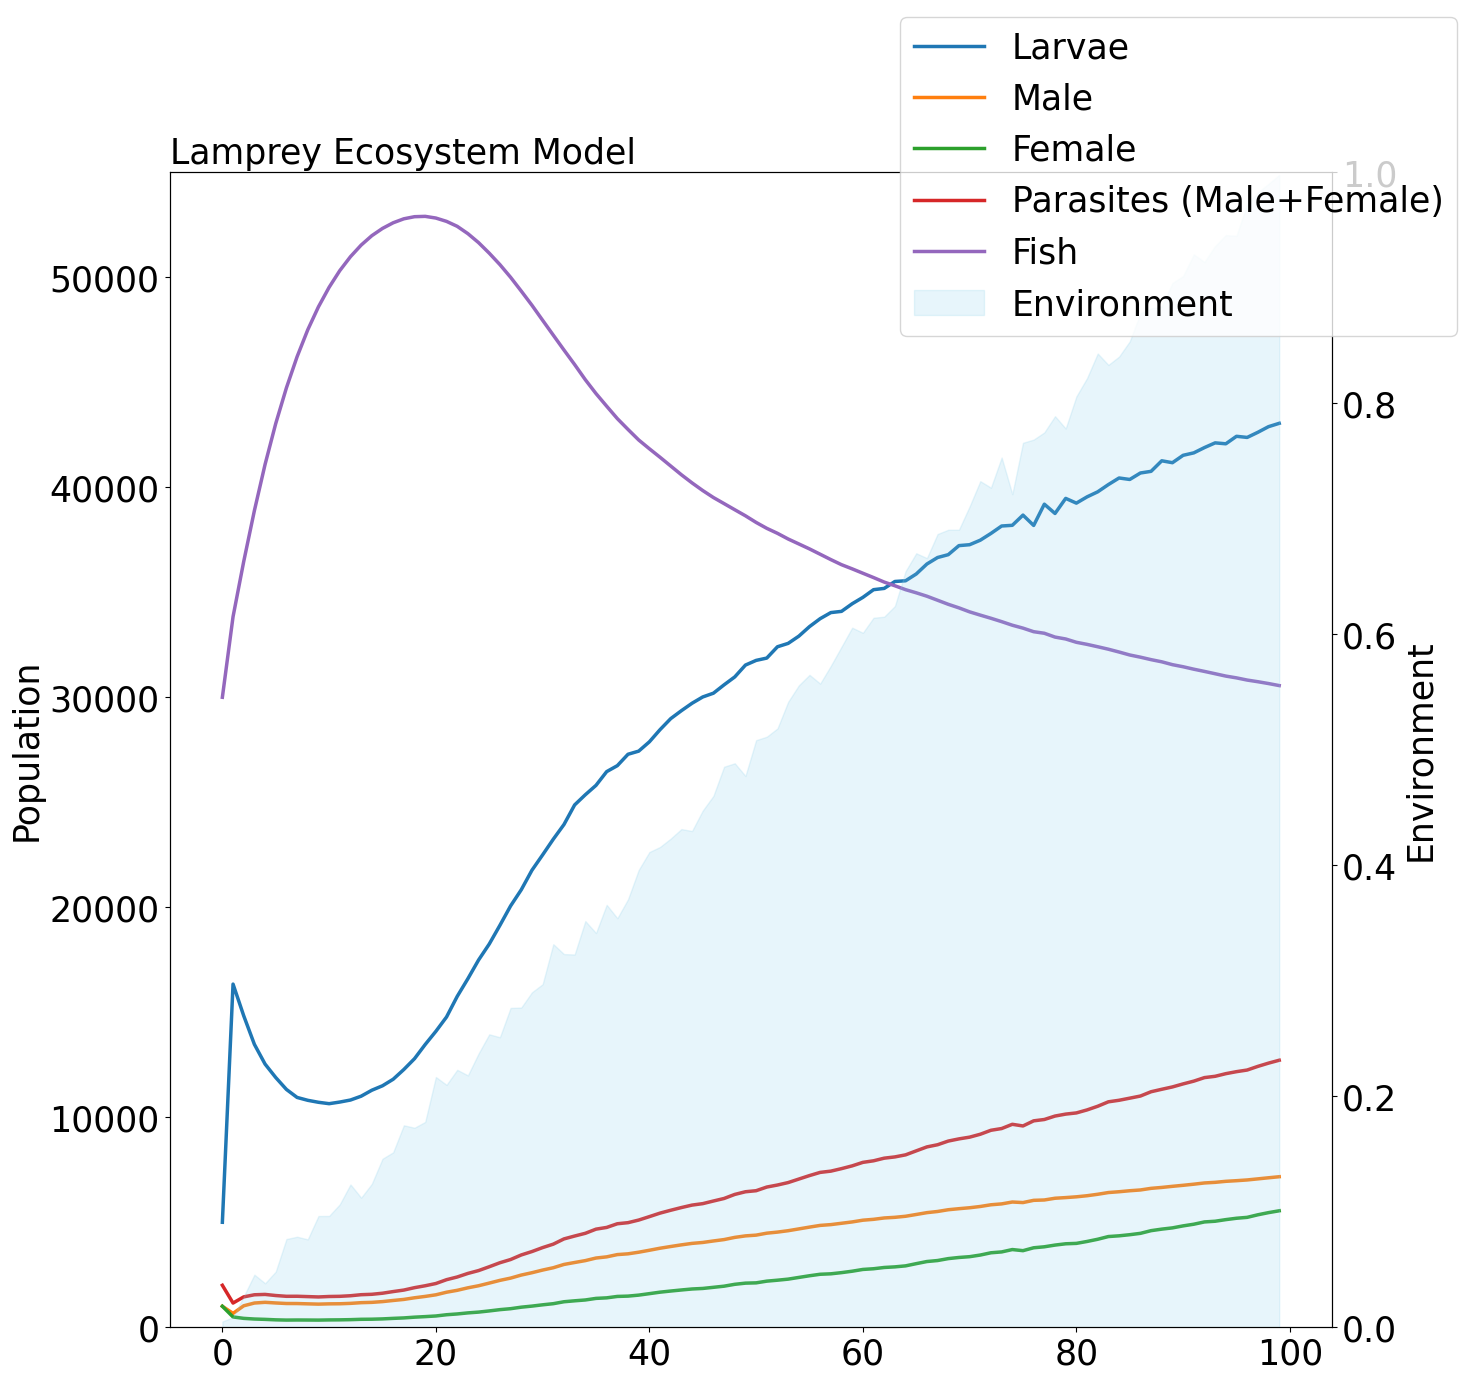

modeling done


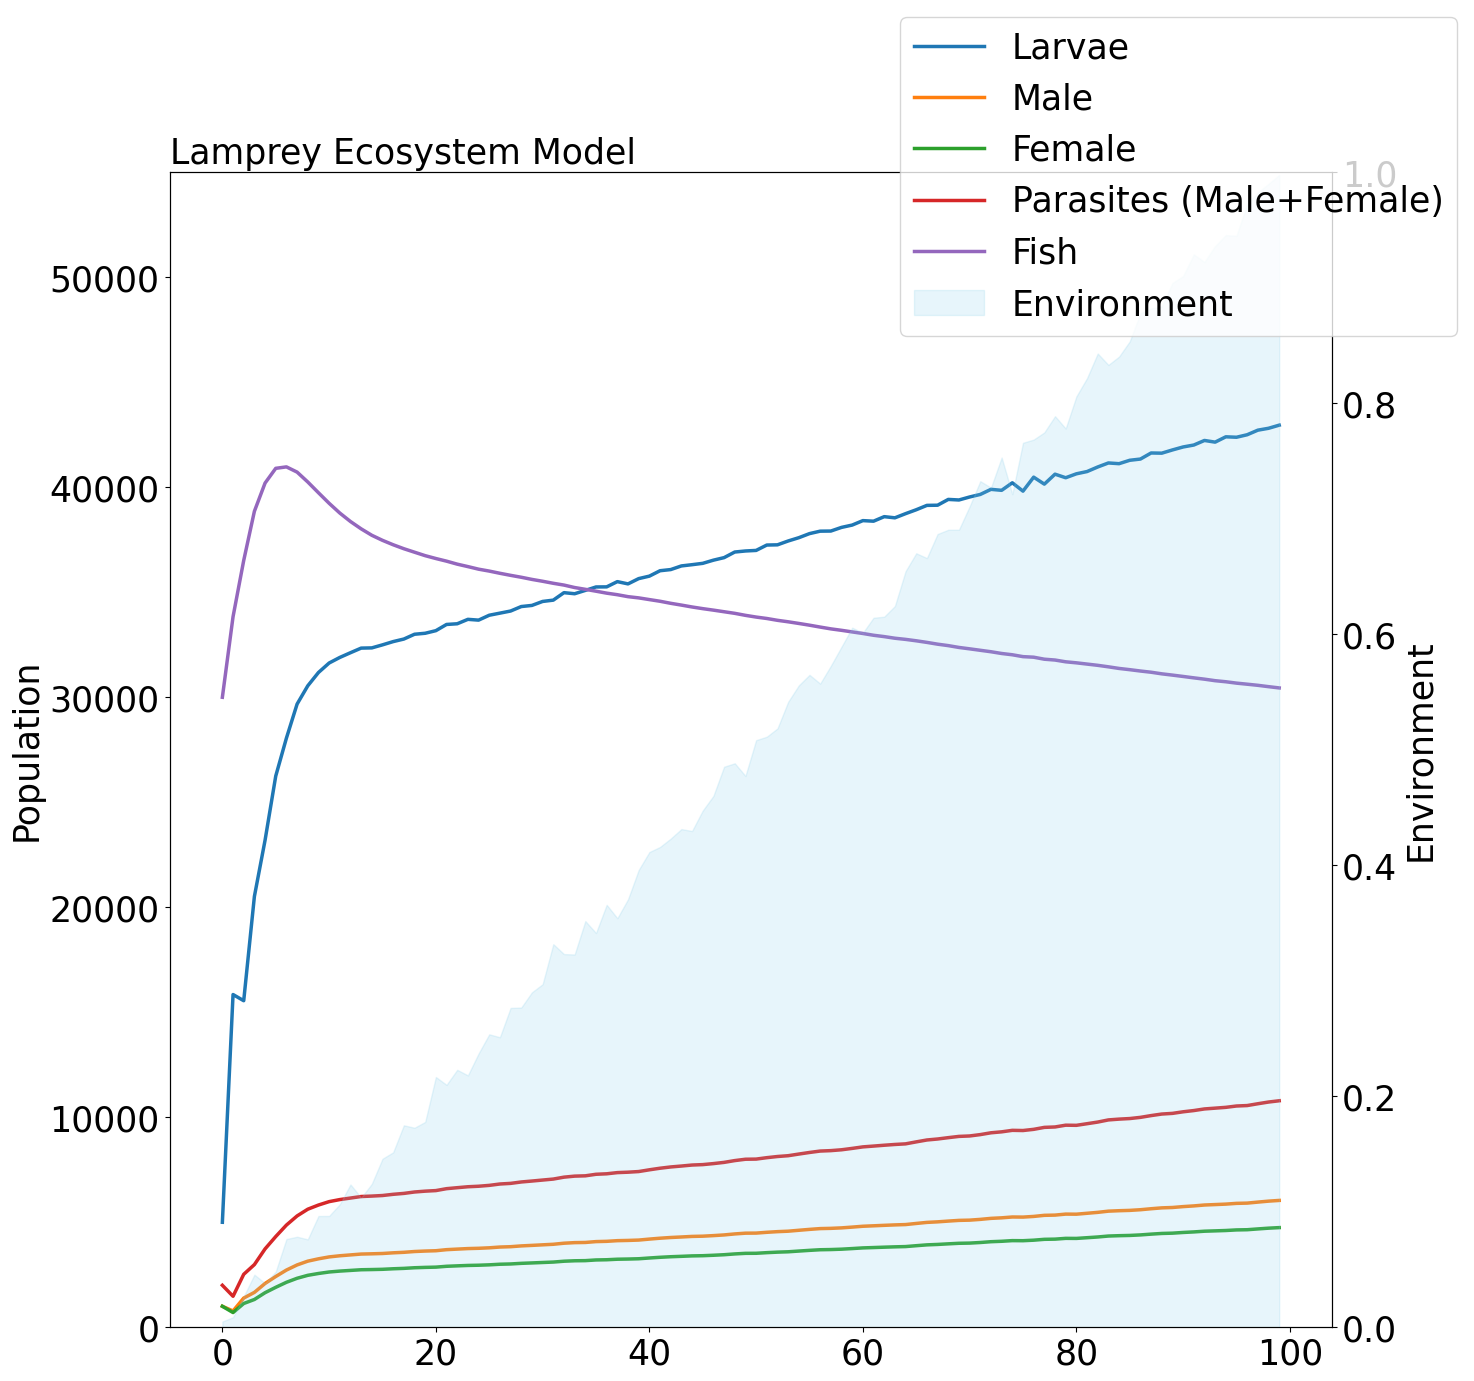

Natural larval deaths with sex ratio change: 8160.618977512814
Natural larval deaths without change: 11927.53397442489
Natural juvenile deaths with sex ratio change: 2827.535032418627
Natural juvenile deaths without change: 3423.1247867831175


In [24]:
model_sex_change = Model(
    noise_E=0.01,
    E='linear'
)
model_sex_change.graph_model(Y_lim=(0, 55000), E_lim=(0, 1))

model_no_change = Model(
    noise_E=0.01,
    E='linear',
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model(Y_lim=(0, 55000), E_lim=(0, 1))

avg_larval_death_change = np.mean(model_sex_change.df['larval_deaths'])
avg_larval_death_no_change = np.mean(model_no_change.df['larval_deaths'])
print(f'Natural larval deaths with sex ratio change: {avg_larval_death_change}')
print(f'Natural larval deaths without change: {avg_larval_death_no_change}')

avg_juv_death_change = np.mean(model_sex_change.df['juvenile_natural_deaths'])
avg_juv_death_no_change = np.mean(model_no_change.df['juvenile_natural_deaths'])
print(f'Natural juvenile deaths with sex ratio change: {avg_juv_death_change}')
print(f'Natural juvenile deaths without change: {avg_juv_death_no_change}')

modeling done


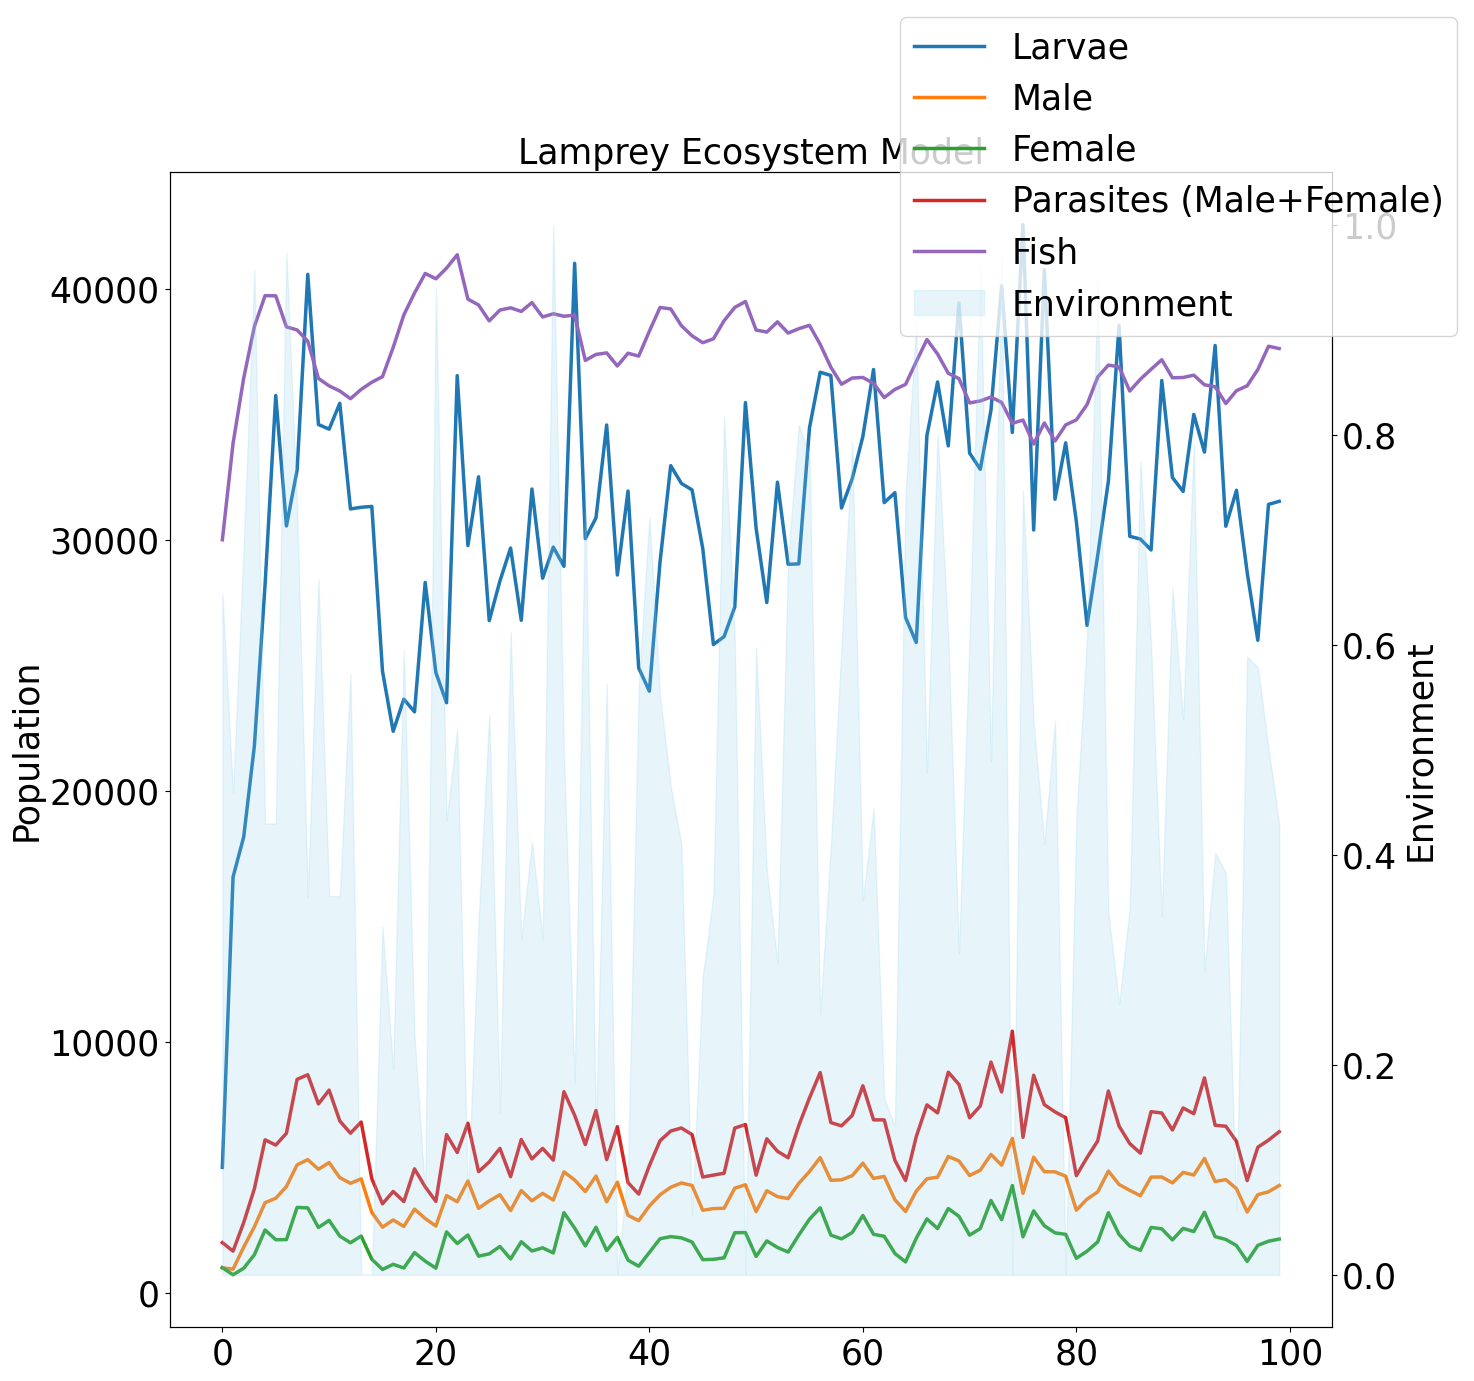

modeling done


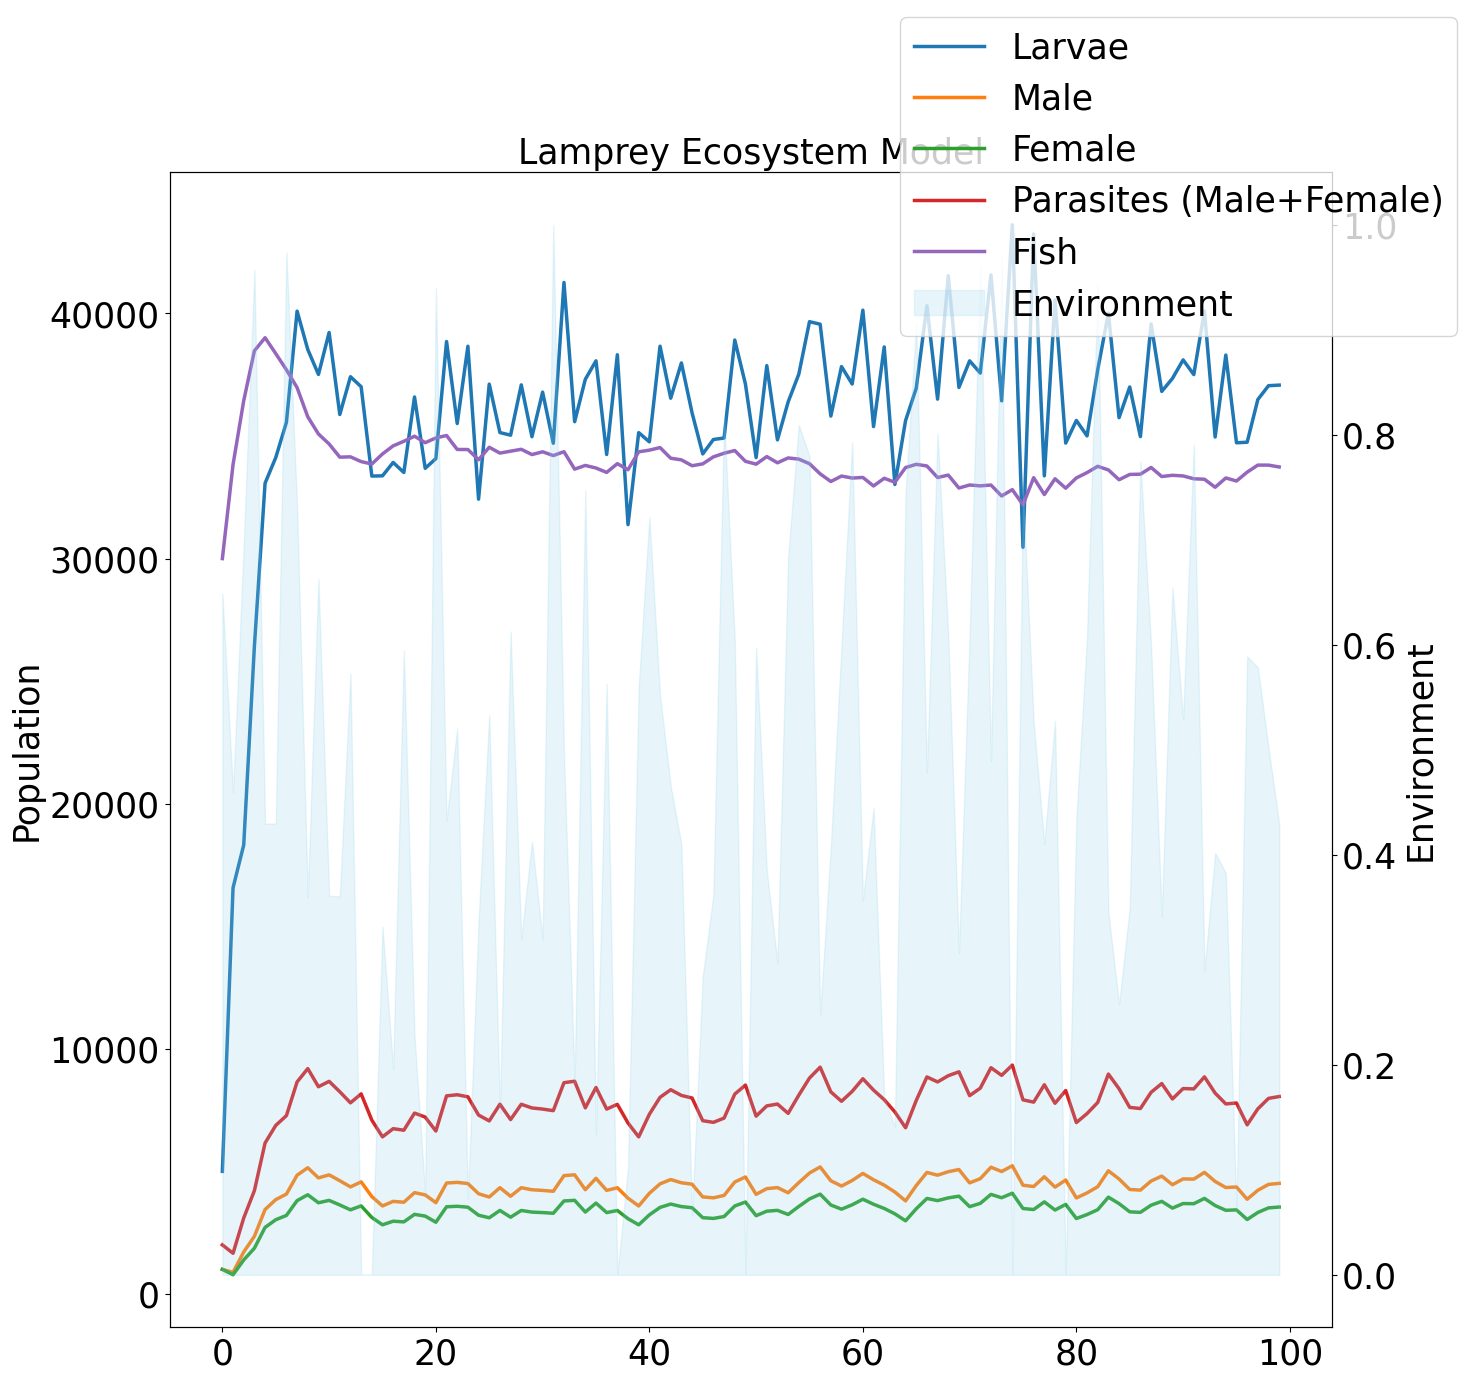

Natural larval deaths with sex ratio change: 9883.586408883091
Natural larval deaths without change: 12493.388764487385
Natural juvenile deaths with sex ratio change: 2770.8359171274465
Natural juvenile deaths without change: 3359.532585006661


In [15]:
model_sex_change = Model(
    noise_E=0.3,
    E='const'
)
model_sex_change.graph_model()

model_no_change = Model(
    noise_E=0.3,
    E='const',
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model()

avg_larval_death_change = np.mean(model_sex_change.df['larval_deaths'])
avg_larval_death_no_change = np.mean(model_no_change.df['larval_deaths'])
print(f'Natural larval deaths with sex ratio change: {avg_larval_death_change}')
print(f'Natural larval deaths without change: {avg_larval_death_no_change}')

avg_juv_death_change = np.mean(model_sex_change.df['juvenile_natural_deaths'])
avg_juv_death_no_change = np.mean(model_no_change.df['juvenile_natural_deaths'])
print(f'Natural juvenile deaths with sex ratio change: {avg_juv_death_change}')
print(f'Natural juvenile deaths without change: {avg_juv_death_no_change}')

modeling done


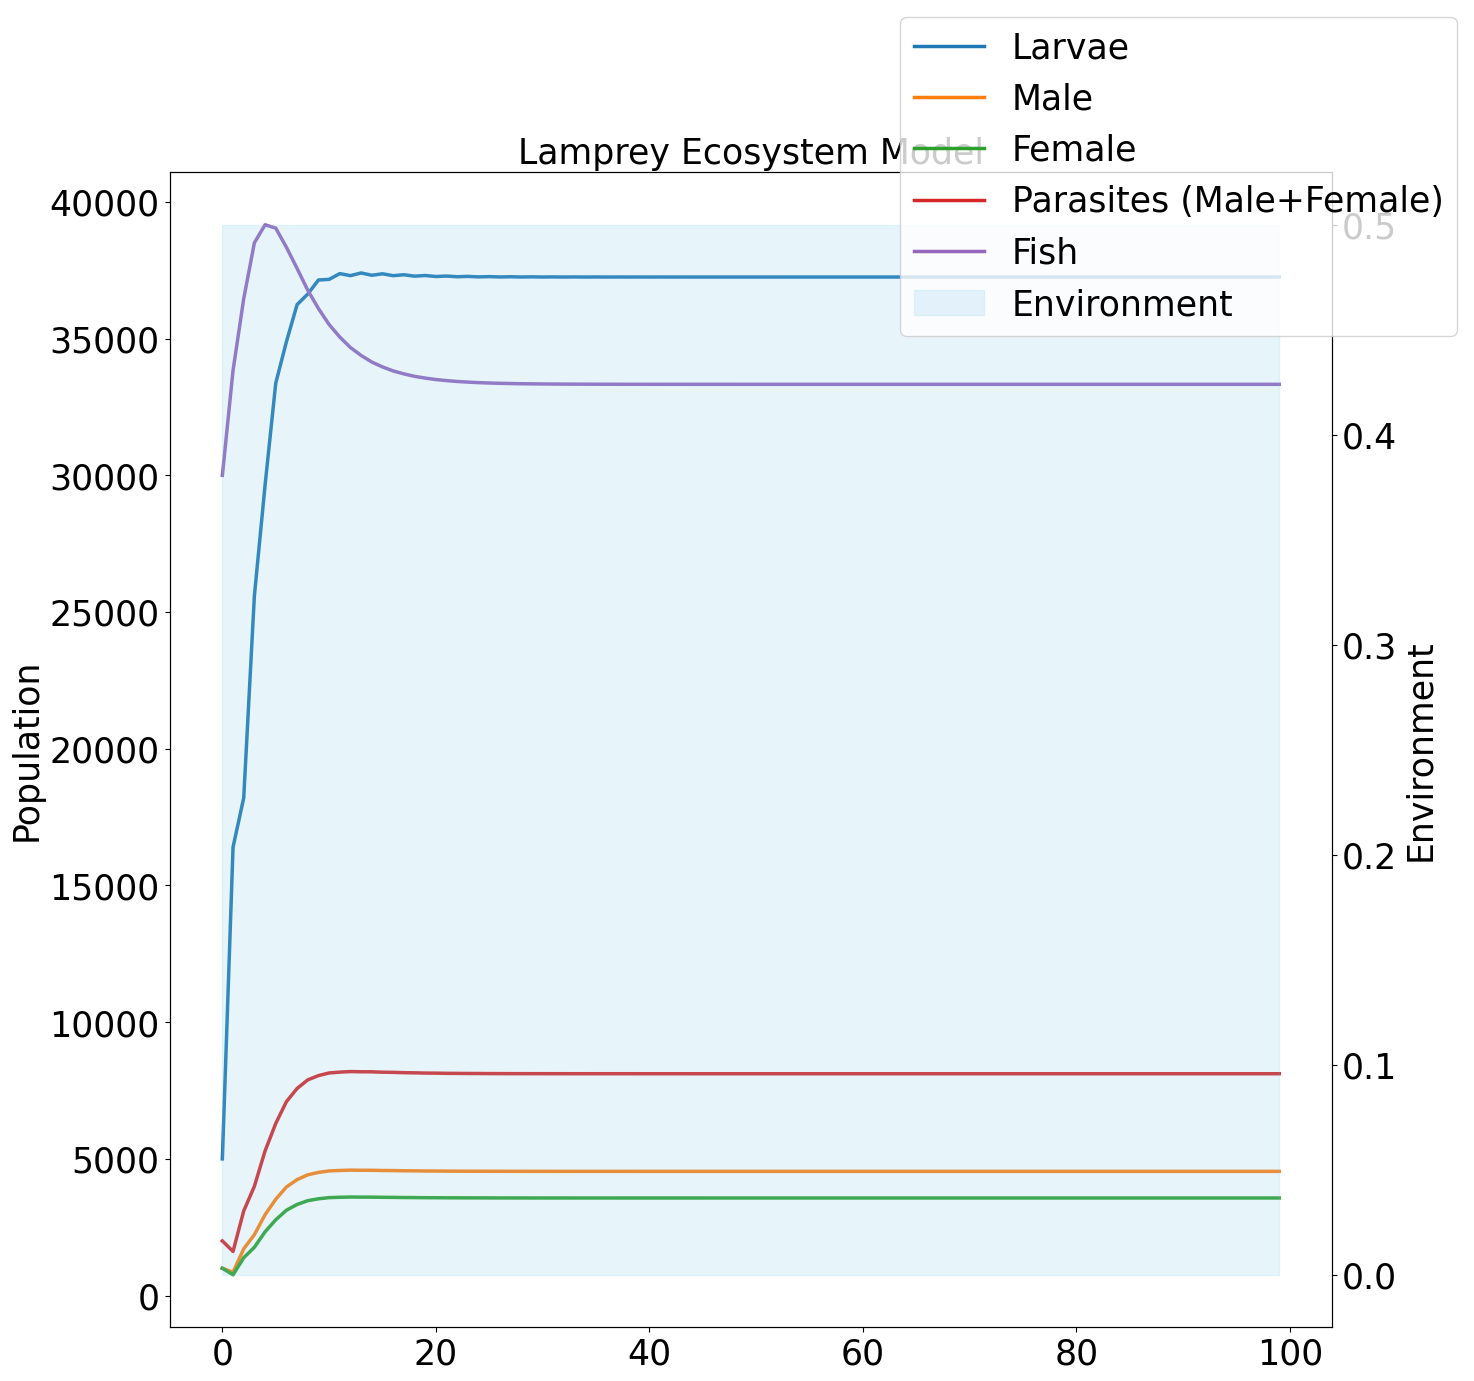

Natural larval deaths with sex ratio change: 9883.586408883091
Natural larval deaths without change: 12376.200405243011
Natural juvenile deaths with sex ratio change: 2770.8359171274465
Natural juvenile deaths without change: 3419.7286247260117


In [16]:
model_no_change = Model(
    noise_E=0.0,
    E='const',
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model()

avg_larval_death_change = np.mean(model_sex_change.df['larval_deaths'])
avg_larval_death_no_change = np.mean(model_no_change.df['larval_deaths'])
print(f'Natural larval deaths with sex ratio change: {avg_larval_death_change}')
print(f'Natural larval deaths without change: {avg_larval_death_no_change}')

avg_juv_death_change = np.mean(model_sex_change.df['juvenile_natural_deaths'])
avg_juv_death_no_change = np.mean(model_no_change.df['juvenile_natural_deaths'])
print(f'Natural juvenile deaths with sex ratio change: {avg_juv_death_change}')
print(f'Natural juvenile deaths without change: {avg_juv_death_no_change}')

notice that both sex ratio and metamorphism rate is related to environmental factor.

in the first graph, the male population stayed almost constant during the period of low food availability. perhaps due to the slower metamorphism rate. in the second graph, both sex ratio and metamorphism rate is fixed, and we see oscillation in both laval and juvenile populations.

a lot less death when they can alter sex ratio.


PDF questions:

1. What is the impact on the larger ecological system when the population of lampreys can  alter its sex ratio?

2. What are the advantages and disadvantages to the population of lampreys?

3. What is the impact on the stability of the ecosystem given the changes in the sex ratios of lampreys?

4. Can an ecosystem with variable sex ratios in the lamprey population offer advantages to  others in the ecosystem, such as parasites?

Added questions:

1. change function E to simulate some random environment changes.

2. change coefficients and see model behaviors bifurcaition etc.

3. make graphs

4. ...

In [7]:
model_sex_change.df

,year,E,L,F,M,H,P,metamorphism_rate,male_rate,female_rate,fish_saturation,larval_saturation,juvenile_saturation,larval_deaths,larval_death_rate,larval_survival_rate,juvenile_natural_deaths,juvenile_death_rate
0,1,0.005160,15393.367441,575.868879,956.509284,33835.636092,1532.378164,0.332174,0.778907,0.221093,0.500000,0.110727,0.182426,1923.931927,0.384786,0.615214,850.000000,0.425000
1,2,0.008955,12720.749623,696.823657,1978.953593,36560.896321,2675.777250,0.331299,0.778082,0.221918,0.579236,0.228426,0.150101,6337.197937,0.411684,0.588316,669.473560,0.436885
2,3,0.027502,13617.048173,691.840765,2189.032342,39181.406828,2880.873107,0.327108,0.774131,0.225869,0.633379,0.191555,0.238284,5042.108255,0.396369,0.603631,1190.739298,0.445007
3,4,0.046884,13870.438223,728.909277,2382.615383,41320.048866,3111.524660,0.322709,0.769983,0.230017,0.682464,0.203389,0.257393,5343.620634,0.392421,0.607579,1303.219289,0.452370
4,5,0.039178,14332.373593,753.212602,2508.209726,43084.484085,3261.422328,0.324452,0.771626,0.228374,0.719773,0.206832,0.280045,5491.821089,0.395937,0.604063,1424.972489,0.457966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,0.926928,40074.999375,2457.511612,3305.182310,32017.416712,5762.693922,0.112699,0.571974,0.428026,0.543602,0.697186,0.600608,7478.065616,0.186918,0.813082,2509.837294,0.431540
95,96,0.926215,40007.971550,2454.802327,3290.534424,31945.226114,5745.336751,0.112842,0.572109,0.427891,0.541931,0.698377,0.594198,7511.044522,0.187425,0.812575,2485.390073,0.431290
96,97,0.953477,40567.458230,2416.314875,3189.752872,31895.039547,5606.067747,0.106380,0.566015,0.433985,0.540437,0.697200,0.592104,7088.250260,0.177171,0.822829,2476.616777,0.431066
97,98,0.962077,40569.055094,2400.928102,3132.463596,31792.667837,5533.391697,0.104105,0.563870,0.436130,0.539398,0.706951,0.575184,7139.920029,0.176001,0.823999,2415.709094,0.430910
